### Tutorial for Bayesian Optimization:


Source: Practical Bayesian Optimization of Machine Learning Algorithms

Link: https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.spatial.distance import pdist, squareform
from gp import GP, SquaredExp, Matern52

sns.set_palette('muted',color_codes=True)
%load_ext autoreload
%autoreload 2
%matplotlib inline

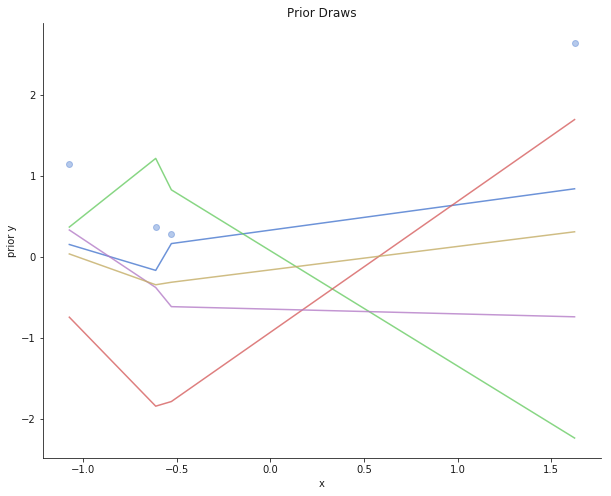

In [4]:
# Plotting helpers         
def plot_draws(x,draws):
    """ Plot the draws from the GP prior or posterior """
    for p in draws.T:
        plt.plot(sorted(x),sorted(p,key=dict(zip(p, x)).get),alpha=0.8)
    plt.xlabel('x')
    plt.ylabel('prior y')
    sns.despine()

def plot_posterior(post_means, post_std, xp):
    sorted_x = sorted(xp.ravel())
    sort_means = np.array(sorted(post_means,key=dict(zip(post_means, xp.ravel())).get))
    sort_std = np.array(sorted(post_std,key=dict(zip(post_std, xp.ravel())).get))
    
    plt.plot(sorted_x,sort_means,alpha=0.7, label='Posterior Mean')
    plt.gca().fill_between(sorted_x, sort_means-2*sort_std, sort_means+2*sort_std, alpha=0.3)

# Example - Initials 
np.random.seed(1)
feats,dim = 1,4
x = np.random.randn(dim,feats)
y = x**2
thetas = np.ones((dim,1))

# Make GP
ggp = GP(x,y,Matern52)
# ggp = GP(x,y,SquaredExp)

# Draw prior functions from GP
prior_draws = ggp.draw_prior(5)

# Plotting prior functions 
plt.figure(figsize=(10,8))
plt.scatter(x,y,alpha=0.4)
plot_draws(x,prior_draws)
plt.title('Prior Draws')
plt.show()


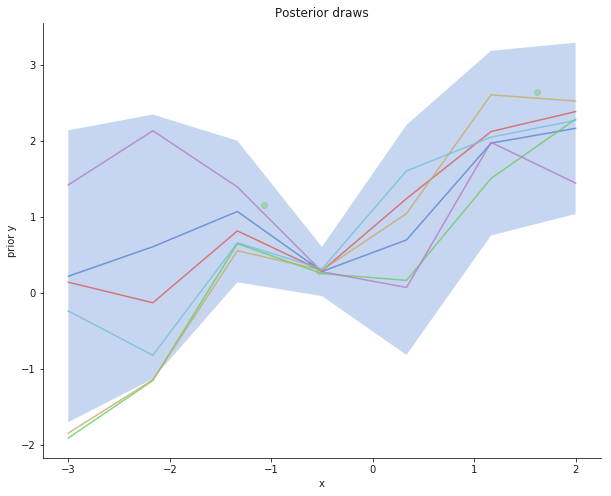

In [5]:
np.random.seed(59)
xp = np.linspace(-3,2,7).reshape(-1,1)

# Draw from the posterior and posterior predictive
post_means, post_stds = ggp.draw_posterior(xp)
pp_draws = ggp.draw_posterior_pred(5)

# Plotting posterior and posterior predictive 
plt.figure(figsize=(10,8))
plot_posterior(post_means, post_stds, xp)
plt.scatter(x,y,alpha=0.4)
plot_draws(xp,pp_draws)
plt.title('Posterior draws')
sns.despine()
plt.show()

In [6]:
np.allclose(ggp.logp(x,y),ggp.logprob(x,y))
ggp.logp(x,y),ggp.logprob(x,y)

(-4.8209187525656363, array([[-0.47742798]]))

In [7]:
import scipy.linalg as spla
np.random.seed(55)
XX = np.random.uniform(1,10,size=(5,5))
XX= XX.T@XX
YY = np.random.randn(5,1)
cho = spla.cholesky(XX,lower=True)
np.linalg.solve(XX,YY)-spla.cho_solve((cho,True),YY) 

array([[  2.22044605e-16],
       [ -8.32667268e-17],
       [  1.66533454e-16],
       [ -1.76941795e-16],
       [  0.00000000e+00]])

In [73]:
from sklearn.gaussian_process import GaussianProcessRegressor

GaussianProcessRegressor(kernel=)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

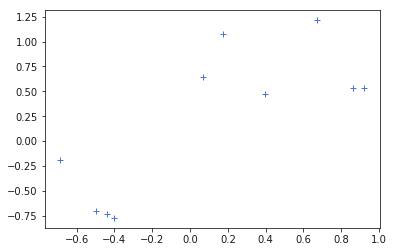

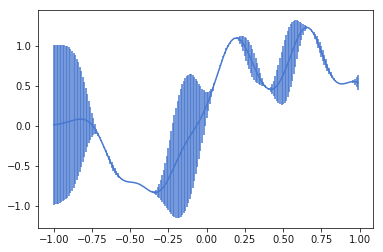

In [3]:
import pylab

def draw_multivariate_gaussian(mean,C):
    ndim = len(mean)
    z = random.standard_normal(ndim)
    
    # Better numerical stabability than cholskey decomposition for
    # near-singular matrices C.
    [U,S,V] = linalg.svd(C)
    A = U * sqrt(S)

    return mean + dot(A,z)

def train(data,kernel):
    mean = zeros(len(data))
    C = covariance(kernel,data)
    return (mean,C)

def predict(x, data, kernel, C, t):
    """
    The prediction equations are from Bishop pg 308. eqns. 6.66 and 6.67.
    """

    k = [kernel(x,y) for y in data]
    Cinv = linalg.inv(C)
    m = dot(dot(k,Cinv),t)
    sigma = kernel(x,x) - dot(dot(k,Cinv),k)
    return (x,m,sigma)

#kernel = OrnsteinKernel(1.0)
kernel = Kernel(1.0, 64.0, 0.0, 0.0)

# Some sample training points.
xpts = random.rand(10) * 2 - 1

# In the context of Gaussian Processes training means simply
# constructing the kernel (or Gram) matrix.
(m,C) = train(xpts, kernel)

# Now we draw from the distribution to sample from the gaussian prior.
t = draw_multivariate_gaussian(m,C)

pylab.figure(0)
pylab.plot(xpts, t, "+")

# Instead of regressing against some known function, lets just see
# what happens when we predict based on the sampled prior. This seems
# to be what a lot of other demo code does.

# Explore the results of GP regression in the target domain.
predictions = [predict(i,xpts,kernel,C,t) for i in arange(-1,1,0.01)]

pylab.figure(1)
x = [prediction[0] for prediction in predictions]
y = [prediction[1] for prediction in predictions]
sigma = [prediction[2] for prediction in predictions]
pylab.errorbar(x,y,yerr=sigma)

pylab.show()

In [ ]:
class GP(object):
    """ Gaussian process object """
    def __init__(self, x, y, kernel, noise=0.0):
        self.obsx = np.array(x)
        self.obsy = np.array(y)
        self.mean = np.mean(y)
        self.amp = np.std(y)
        self.kernel = kernel
        self.dim = x.shape[1]
        self.noise = noise
        
    def set_params(self,**kwargs):
        """ Sets arguments for the GP object. Options are: {x,y, kernel, thetas, dim, means} """
        for key, value in kwargs.items():
            setattr(self, key, value)
        
    def cov(self,x,xp,thetas=None): 
        """ Get the covariance matrix for the GP based on observed data """
        if thetas is None:
            thetas = np.ones(self.dim)
        return self.amp*self.kernel(x,xp,thetas)
    
    def draw_prior(self,ndraws,thetas=None):
        """ Draw from the prior over the functions of the GP. Math in draw_posterior """
        dim = self.obsx.shape[0]
        # The diagonal addition below is for numeric stability
        cov_mat = self.cov(self.obsx,self.obsx,thetas)+np.eye(dim)*1e-7
        L_chol = np.linalg.cholesky(cov_mat)
        return L_chol @ np.random.normal(size=(dim, ndraws))

    def draw_posterior(self,xp,thetas=None):
        """ The math is given as follows:
        Q: Do we want to do a noisy version or not? 
        
        Covaraince matrix can be broken into three sections 
        
        | K   K* |
        | K*T K**|
        
        where K = kernel(x,x), K* = kernel(x,x*), K** = kernel(x*,x*)
        
        In math the mean of the posterior is given by: 
            mu = K*T @ K^-1 @ y where dimensions are (MxN), (NXN), (Nx1) result: (Mx1)
        
        We use a cholesky decomp so we dont (stupidly) take the inverse of K 
        Since K = LL^T with cholesky: K*T @ L^-1@L^-1^T @ y
        We can set up K*T @ L^-1 and L^-1^T @ y as lower tri eq's to solve, giving:
            mu = solve(L,K*T).T @ solve(L, y) 
        
        In math the covariance of the posterior is given by: 
            cov = K** - K*T @ K^-1 @ K* where dimensions are (MxM), (MxN), (NxN) (NxM) result: (MxM)
        
        The covariance can be solved for with similar numerical tricks: 
        Since K = LL^T with cholesky: K** -  K*T @ L^-1@L^-1^T @ K*
            cov = K** -  solve(L,K*T).T @ solve(L, K*T)
        
        Source: http://www.cs.ubc.ca/~nando/540-2013/lectures/l6.pdf
        """
        dim1, dim2 = self.obsx.shape[0],xp.shape[0]
        
        x_diff = self.obsy - np.mean(self.obsx)
        
        # Get covariance matrix sections
        cov = self.cov(self.obsx,self.obsx) + np.eye(dim1)*1e-7 + np.eye(dim1)*self.noise
        cov_star = self.cov(self.obsx,xp) + np.eye(dim1,dim2)*1e-7 + np.eye(dim1,dim2)*self.noise
        cov_ss = self.cov(xp,xp) + np.eye(dim2)*1e-7 + np.eye(dim2)*self.noise
        
        # Get useful cholsesky decompositions
        L = np.linalg.cholesky(cov)
        Linv_cov_s = np.linalg.solve(L,cov_star)
        
        # Calculate the posterior means and covariance matrix
        self.means = Linv_cov_s.T @ np.linalg.solve(L, self.obsy.reshape(-1,1))
        self.cmat = cov_ss - Linv_cov_s.T @ Linv_cov_s +np.eye(dim2)*1e-7
        self.std = np.sqrt(np.diag(cov_ss) - np.sum(Linv_cov_s**2, axis=0))
        
        return self.means.ravel(), self.std 
    
    def draw_posterior_pred(self,ndraws):
        return self.means + self.cmat@np.random.normal(size=(self.cmat.shape[0],ndraws))

